In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from abc import abstractmethod
import torch
from torch import Tensor, nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np
from collections import OrderedDict, defaultdict

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'); DEVICE

device(type='cpu')

# Muons

## Muon generation

In [4]:
def generate_batch(n:int) -> Tensor:
    r'''
    Return tensor is (muons, coords),
    coords = (x~Uniform[0,1], y~Uniform[0,1], p=100GeV, theta_x~cos2(a) a~Uniform[0,0.5pi], theta_y~Uniform[0,2pi])
    '''
    
    batch = torch.stack([
        torch.rand(n),
        torch.rand(n),
        torch.zeros(n)+100,
        torch.clamp(torch.randn(n)/10,-math.pi/2,math.pi/2),  # Fix this
        torch.clamp(torch.randn(n)/10,-math.pi/2,math.pi/2)   # Fix this
    ], dim=1)
    return batch

In [5]:
x = generate_batch(10000)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


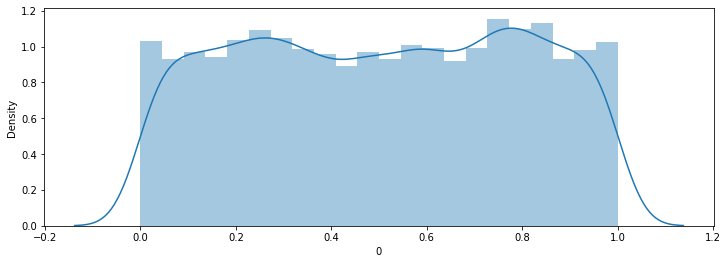

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


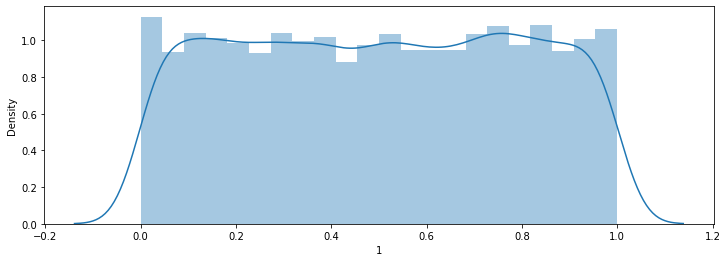

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


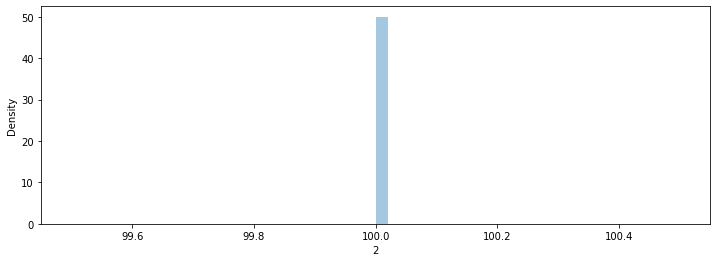

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


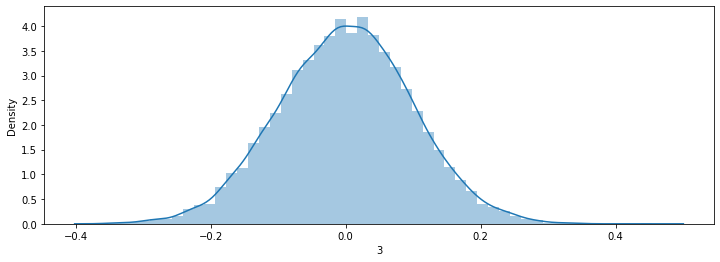

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


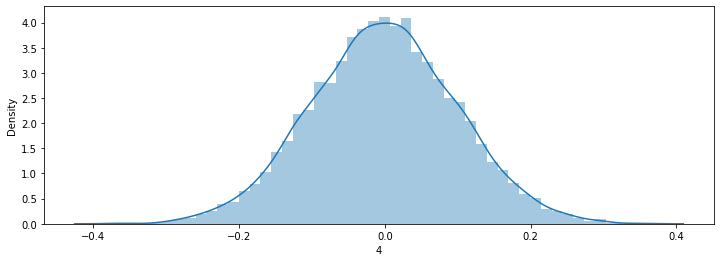

In [6]:
for i in range(x.shape[1]):
    try:
        plt.figure(figsize=(12,4))
        sns.distplot(x[:,i])
        plt.xlabel(i)
        plt.show()
    except RuntimeError:
        pass

In [7]:
m = generate_batch(100)

## Muon Batch

In [8]:
class MuonBatch:
    def __init__(self, muons:Tensor, init_z:float, device:torch.device=DEVICE):
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:p=100GeV, 3:theta_x~cos2(a) a~Uniform[0,0.5pi], 4:theta_y~cos2(a) a~Uniform[0,0.5pi]
        '''
        
        self.device = device
        self.muons = muons.to(self.device)
        self.z = Tensor([init_z]).to(self.device)
        self.hits = defaultdict(lambda: defaultdict(list))
        self.xy_hist = OrderedDict({})
        
    def __repr__(self) -> str:
        return f"Batch of {len(self)} muons"
        
    def __len__(self) -> int: return len(self.muons)
    
    @property
    def muons(self) -> Tensor: return self._muons
    
    @muons.setter
    def muons(self, muons:Tensor) -> None: self._muons = muons
        
    @property
    def x(self) -> Tensor: return self._muons[:,0]
    
    @x.setter
    def x(self, x:Tensor) -> None: self._muons[:,0] = x
        
    @property
    def y(self) -> Tensor: return self._muons[:,1]
    
    @y.setter
    def y(self, y:Tensor) -> None: self._muons[:,1] = y
        
    @property
    def xy(self) -> Tensor: return self._muons[:,:2]
    
    @xy.setter
    def xy(self, xy:Tensor) -> None: self._muons[:,:2] = xy
        
    @property
    def p(self) -> Tensor: return self._muons[:,2]
    
    @p.setter
    def p(self, p:Tensor) -> None: self._muons[:,2] = p
        
    @property
    def theta_x(self) -> Tensor: return self._muons[:,3]
    
    @theta_x.setter
    def theta_x(self, theta_x:Tensor) -> None: self._muons[:,3] = theta_x
        
    @property
    def theta_y(self) -> Tensor: return self._muons[:,4]
    
    @theta_y.setter
    def theta_y(self, theta_y:Tensor) -> None: self._muons[:,4] = theta_y
        
    @property
    def theta(self) -> Tensor: return torch.sqrt(((self.theta_x)**2)+((self.theta_y)**2))
    
    @theta.setter
    def theta(self, theta:Tensor) -> None: raise NotImplementedError()
        
    def propagate(self, dz:float) -> None:
        self.x = self.x+(dz*torch.tan(self.theta_x))
        self.y = self.y+(dz*torch.tan(self.theta_y))
        self.z -= dz
        
    def get_xy_mask(self, lw:Tensor) -> Tensor:
        return (self.x >= 0)*(self.x < lw[0])*(self.y >= 0)*(self.y < lw[1])
    
    def snapshot_xyz(self) -> None:
        self.xy_hist[self.z] = self.xy.cpu().detach().clone().numpy()
        
    def append_hits(self, hits:Dict[str,Tensor], pos:str) -> None:
        for k in hits:
            self.hits[pos][k].append(hits[k])
        
    def get_hits(self, lw:Tensor) -> Tensor:
        m = self.get_xy_mask(lw)
        return {p:{c:torch.stack(self.hits[p][c], dim=1)[m] for c in self.hits[p]} for p in self.hits}
    
    def dtheta_x(self, mu:'MuonBatch') -> Tensor:
        return torch.abs(self.theta_x-mu.theta_x)
    
    def dtheta_y(self, mu:'MuonBatch') -> Tensor:
        return torch.abs(self.theta_y-mu.theta_y)
    
    def dr(self, mu:'MuonBatch') -> Tensor:
        return torch.sqrt((self.dtheta_x(mu)**2)+(self.dtheta_y(mu)**2))
    
    def copy(self) -> 'MuonBatch':
        return MuonBatch(self._muons.detach().clone(), init_z=self.z, device=self.device)

In [9]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [10]:
batch2 = MuonBatch(generate_batch(1000), init_z=1)

In [11]:
d = batch.dtheta_x(batch2); d.min(),d.max()

(tensor(7.8293e-05), tensor(0.4734))

In [12]:
d = batch.dr(batch2); d.min(),d.max()

(tensor(0.0044), tensor(0.5110))

In [13]:
batch.xy

tensor([[0.0025, 0.3189],
        [0.1009, 0.3036],
        [0.5458, 0.1444],
        ...,
        [0.2004, 0.3752],
        [0.5992, 0.8629],
        [0.1777, 0.1633]])

In [14]:
batch.snapshot_xyz()

In [15]:
batch.xy_hist

OrderedDict([(tensor([1.]),
              array([[0.00254977, 0.318874  ],
                     [0.10090941, 0.30357277],
                     [0.54575276, 0.14435726],
                     ...,
                     [0.20042127, 0.37521452],
                     [0.599194  , 0.8629052 ],
                     [0.17766267, 0.16326058]], dtype=float32))])

In [16]:
batch.propagate(0.1)

In [17]:
batch.xy

tensor([[-0.0059,  0.3190],
        [ 0.1026,  0.3014],
        [ 0.5530,  0.1287],
        ...,
        [ 0.1926,  0.3916],
        [ 0.5978,  0.8609],
        [ 0.2007,  0.1622]])

In [18]:
batch.xy_hist

OrderedDict([(tensor([0.9000]),
              array([[0.00254977, 0.318874  ],
                     [0.10090941, 0.30357277],
                     [0.54575276, 0.14435726],
                     ...,
                     [0.20042127, 0.37521452],
                     [0.599194  , 0.8629052 ],
                     [0.17766267, 0.16326058]], dtype=float32))])

In [19]:
batch.snapshot_xyz()

In [20]:
batch.xy_hist

OrderedDict([(tensor([0.9000]),
              array([[-0.00585111,  0.31903183],
                     [ 0.1025828 ,  0.30139172],
                     [ 0.55295676,  0.12872444],
                     ...,
                     [ 0.19261299,  0.3916071 ],
                     [ 0.59777087,  0.860872  ],
                     [ 0.20073196,  0.16215122]], dtype=float32))])

# Volume+Detector

In [21]:
class Layer(nn.Module):
    def __init__(self, lw:Tensor, z:float, size:float, device:torch.device=DEVICE):
        super().__init__()
        self.lw,self.z,self.size,self.device = lw,Tensor([z]),size,device
        self.rad_length = None
        
    def scatter_and_propagate(self, mu:MuonBatch, deltaz:float) -> None:
        """
        This function produces a model of multiple scattering through a layer of material
        of depth deltaz
        
        TODO: Expand to sum over traversed voxels
        """
        
        if self.rad_length is not None:
            mask = mu.get_xy_mask(self.lw)  # Only scatter muons inside volume
            n = mask.sum()
            xy_idx = self.mu_abs2idx(mu, mask)

            x0 = self.rad_length[xy_idx[:,0],xy_idx[:,1]]*deltaz/torch.cos(mu.theta[mask])
            z1 = torch.randn(n, device=self.device)
            z2 = torch.randn(n, device=self.device)
            
            
            theta0 = (0.0136/mu.p[mask]) * torch.sqrt(x0) # Ignore due to inversion problems * (1+(0.038*torch.log(x0)))
            theta_msc = math.sqrt(2) * z2 * theta0
            phi_msc = torch.rand(n, device=self.device)*2*math.pi
            dh_msc = deltaz*torch.sin(theta0)*((z1/math.sqrt(12))+(z2/2))
            dx_msc = math.sqrt(2) * dh_msc * torch.cos(phi_msc) * torch.cos(mu.theta_x[mask]) # we need to account for direction of incident particle!
            dy_msc = math.sqrt(2) * dh_msc * torch.sin(phi_msc) * torch.cos(mu.theta_y[mask]) # ... so we project onto the surface of the layer

            # Update to position at scattering. Note that if a track incides on a layer
            # with angle theta_mu, the dx and dy displacements are relative to zero angle
            # (generation of MSC formulas are oblivious of angle of incidence) so we need
            # to rescale them by cos of thetax and thetay. 
            # ---------------------------------------------------------------------------
            mu.x[mask]       = mu.x[mask] + dx_msc 
            mu.y[mask]       = mu.y[mask] + dy_msc
            mu.propagate(deltaz)
            mu.theta_x[mask] = mu.theta_x[mask] + theta_msc*torch.cos(phi_msc)
            mu.theta_y[mask] = mu.theta_y[mask] + theta_msc*torch.sin(phi_msc)
        else:
            mu.propagate(deltaz)
        
    def mu_abs2idx(self, mu:MuonBatch, mask:Optional[Tensor]=None) -> Tensor:
        xy = mu.xy
        if mask is not None: xy = xy[mask]
        return self.abs2idx(xy)
    
    def abs2idx(self, xy:Tensor) -> Tensor:
        return torch.floor(xy/self.size).long()
                         
    @abstractmethod
    def forward(self, mu:MuonBatch) -> None: pass

## Volume

In [23]:
X0 = {'beryllium':0.3528,  # m
      'carbon':0.1932,
      'aluminium':0.08897,
      'silicon':0.0937,
      'iron':0.01757,
      'copper':0.01436,
      'lead':0.005612,
     # 'air':312.22
     }

In [24]:
def arb_rad_length(z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
#     if z >= 0.3 and z <= 0.6: rad_length[3:7,3:7] = X0['lead']
    if z == 0.6 : rad_length[...] = X0['lead']
        
    return rad_length

In [25]:
d = arb_rad_length(0.6, lw=Tensor([1,1]), size=0.1);d

tensor([[0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056]])

In [26]:
x = generate_batch(10)

In [27]:
idxs = torch.floor(x[:,:2]/0.1).long()

In [28]:
d[idxs[:,0],idxs[:,1]]

tensor([0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
        0.0056])

In [29]:
class PassiveLayer(Layer):
    def __init__(self, rad_length_func:Callable[[float,Tensor,float],float],
                 lw:Tensor, z:float, size:float, device:torch.device=DEVICE):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.rad_length = rad_length_func(self.z, self.lw, size=self.size).to(self.device)
                   
    def forward(self, mu:MuonBatch) -> None:
        n = 2
        for _ in range(n):
            self.scatter_and_propagate(mu, deltaz=self.size/n)

In [30]:
vl = PassiveLayer(arb_rad_length, lw=Tensor([1,1]), z=0.5, size=0.1)

In [31]:
batch = MuonBatch(generate_batch(1000), 1.0)

In [32]:
batch.xy

tensor([[0.1828, 0.0281],
        [0.8258, 0.0660],
        [0.7835, 0.1079],
        ...,
        [0.6069, 0.6040],
        [0.7305, 0.6563],
        [0.1662, 0.0286]])

In [33]:
batch.theta_x

tensor([ 1.2877e-01,  1.1092e-02, -4.7676e-02, -4.2143e-02, -1.5362e-01,
         1.4722e-01, -1.5022e-01,  8.5331e-02, -2.4158e-01,  9.8491e-02,
         7.1702e-02,  1.3070e-01, -9.0106e-02, -1.6754e-02, -6.1208e-02,
        -1.8106e-01, -1.5750e-02,  1.1407e-01, -1.6471e-01,  8.7110e-02,
         5.5525e-02, -6.5606e-02, -1.1052e-01, -2.9156e-02, -7.6465e-02,
        -1.1729e-02, -4.1094e-02, -1.5015e-01,  4.6585e-02,  4.2707e-02,
         2.5989e-01, -7.0052e-02,  2.0033e-02, -1.9571e-01, -2.0063e-01,
         8.1838e-02, -5.3047e-02, -4.8162e-02, -5.0607e-02, -1.1465e-01,
        -2.4254e-03, -4.5510e-02,  1.4926e-01,  6.3117e-03,  1.5757e-01,
         1.8735e-01, -4.3377e-02,  6.9476e-02,  4.4594e-02, -4.1064e-02,
         4.0515e-02, -1.3892e-01,  7.0033e-02,  2.6920e-02, -2.2261e-01,
        -1.1886e-01, -3.7695e-02, -2.1713e-02, -7.9717e-02, -1.2194e-01,
         1.2768e-01, -6.1016e-02, -1.0585e-01,  5.9589e-02,  8.0948e-02,
        -1.5499e-01,  3.4352e-02,  1.7990e-01, -3.3

In [34]:
batch.z

tensor([1.])

In [35]:
vl(batch)

In [36]:
batch.theta_x

tensor([ 1.2875e-01,  1.1097e-02, -4.7623e-02, -4.2179e-02, -1.5366e-01,
         1.4724e-01, -1.5021e-01,  8.5302e-02, -2.4161e-01,  9.8482e-02,
         7.1736e-02,  1.3069e-01, -9.0107e-02, -1.6755e-02, -6.1186e-02,
        -1.8108e-01, -1.5741e-02,  1.1410e-01, -1.6472e-01,  8.7139e-02,
         5.5528e-02, -6.5571e-02, -1.1053e-01, -2.9150e-02, -7.6488e-02,
        -1.1741e-02, -4.1081e-02, -1.5011e-01,  4.6560e-02,  4.2679e-02,
         2.5983e-01, -7.0079e-02,  2.0031e-02, -1.9573e-01, -2.0063e-01,
         8.1807e-02, -5.3020e-02, -4.8187e-02, -5.0623e-02, -1.1464e-01,
        -2.4245e-03, -4.5536e-02,  1.4925e-01,  6.2944e-03,  1.5757e-01,
         1.8735e-01, -4.3376e-02,  6.9452e-02,  4.4529e-02, -4.1076e-02,
         4.0536e-02, -1.3890e-01,  7.0026e-02,  2.6851e-02, -2.2262e-01,
        -1.1888e-01, -3.7669e-02, -2.1708e-02, -7.9674e-02, -1.2196e-01,
         1.2774e-01, -6.1063e-02, -1.0583e-01,  5.9581e-02,  8.0936e-02,
        -1.5501e-01,  3.4394e-02,  1.7988e-01, -3.3

In [37]:
batch.xy

tensor([[0.1958, 0.0308],
        [0.8269, 0.0766],
        [0.7787, 0.1113],
        ...,
        [0.6242, 0.5939],
        [0.7524, 0.6712],
        [0.1702, 0.0242]])

In [38]:
batch.z

tensor([0.9000])

## Detector

### Cost functions

In [39]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

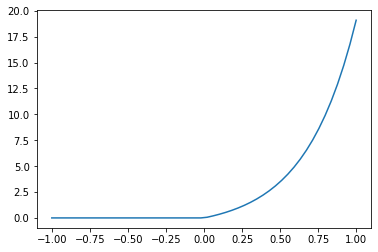

In [40]:
x = torch.linspace(-1,1,50)
plt.plot(x,eff_cost(x))

In [41]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x)**2

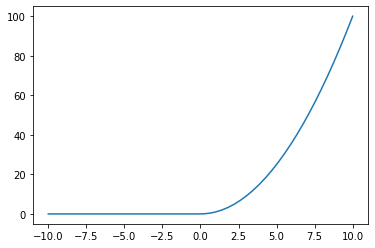

In [42]:
x = torch.linspace(-10,10,50)
plt.plot(x,res_cost(x))

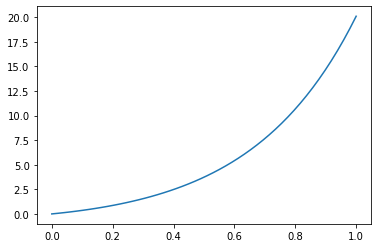

In [43]:
x = torch.linspace(0,1,50)
plt.plot(x,res_cost(x)+eff_cost(x))

### layer

In [44]:
class DetectorLayer(Layer):
    def __init__(self, pos:str, init_res:float, init_eff:float, lw:Tensor, z:float, size:float,
                 eff_cost_func:Callable[[Tensor],Tensor], res_cost_func:Callable[[Tensor],Tensor], device:torch.device=DEVICE):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.pos = pos
        self.resolution = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_res)
        self.efficiency = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_eff)
        self.eff_cost_func,self.res_cost_func = eff_cost_func,res_cost_func
        
    def get_hits(self, mu:MuonBatch) -> Dict[str,Tensor]:  # to dense and add precision
        mask = mu.get_xy_mask(self.lw)
        res,eff = torch.zeros(len(mu), device=self.device),torch.zeros(len(mu), device=self.device)  # Zero detection outside detector
        xy_idxs = self.mu_abs2idx(mu, mask)
        res[mask] = self.resolution[xy_idxs[:,0],xy_idxs[:,1]]
        eff[mask] = self.efficiency[xy_idxs[:,0],xy_idxs[:,1]]
        
        # TODO clamp deviation so that reco hit is always inside gen hit's detector element
        hits = {'xy': torch.stack([mu.x+(torch.randn(len(mu), device=self.device)/(torch.abs(res)+1e-17)),  # Inverse resolution
                                   mu.y+(torch.randn(len(mu), device=self.device)/(torch.abs(res)+1e-17))], dim=1),
                'z': self.z.expand_as(mu.x)[:,None]-(self.size/2)}
        return hits
        
    def forward(self, mu:MuonBatch) -> None:
        self.scatter_and_propagate(mu, self.size/2)
        mu.append_hits(self.get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, self.size/2)
        
    def get_cost(self) -> Tensor:
        return self.eff_cost_func(self.efficiency).sum()+self.res_cost_func(self.resolution).sum()

In [45]:
batch = MuonBatch(generate_batch(1000), 1)

In [46]:
dl = DetectorLayer('above', 1,1,Tensor([1,1]),1,0.1, eff_cost_func=eff_cost, res_cost_func=res_cost)

In [47]:
dl.resolution

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

In [48]:
dl(batch)
dl(batch)
dl(batch)

In [49]:
hits = batch.get_hits(Tensor([1,1]))

In [50]:
hits['above']['xy'].shape

torch.Size([952, 3, 2])

In [51]:
hits['above']['eff'].shape

torch.Size([952, 3])

# Volume 

In [52]:
class Volume(nn.Module):
    def __init__(self, layers:nn.ModuleList):
        super().__init__()
        self.layers = layers
        
    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]
    
    def get_passives(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]
    
    def get_rad_cube(self) -> Tensor:
        vols = reversed(self.get_passives())
        return torch.stack([v.rad_length for v in vols], dim=0)
    
    def lookup_coords(self, xyz:Tensor, passive_only:bool) -> Tensor:
        r'''Assume same size for all layers for now and no intermedeate detector layers'''
        if len(xyz.shape) == 1: xyz = xyz[None,:]
        sz = self.layers[0].size
        if passive_only: xyz[:,2] = xyz[:,2]-self.get_passives()[-1].z+sz
        return torch.floor(xyz/sz).long()
            
        
    def forward(self, mu:MuonBatch) -> Tensor:  # Expand to take volume as input, too
        cost = None
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()
            if hasattr(l, 'get_cost'):  # Get cost of detector layer
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost+l.get_cost()
        return cost

In [53]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 10000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [54]:
layers = get_layers()

In [55]:
volume = Volume(layers=layers); volume

Volume(
  (layers): ModuleList(
    (0): DetectorLayer()
    (1): DetectorLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PassiveLayer()
    (8): DetectorLayer()
    (9): DetectorLayer()
  )
)

In [56]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [57]:
volume(batch)

tensor(4.0000e+10, grad_fn=<AddBackward0>)

In [58]:
hits = batch.get_hits(Tensor([1,1]))

In [59]:
hits['above']['xy'].shape

torch.Size([837, 2, 2])

In [60]:
volume.get_rad_cube().shape

torch.Size([6, 10, 10])

# Atomic number reco

## Compute deviations and scatter locations

In [61]:
def jacobian(y:Tensor, x:Tensor, create_graph=False, allow_unused=True):
    r'''Compute full jacobian matrix for single tensor. Call twice for hessian.
    Copied from https://gist.github.com/apaszke/226abdf867c4e9d6698bd198f3b45fb7 credits: Adam Paszke
    TODO: Fix this to work batch-wise (maybe https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa)'''
    jac = []
    flat_y = y.reshape(-1)
    grad_y = torch.zeros_like(flat_y)
    for i in range(len(flat_y)):
        grad_y[i] = 1.  # may need to use value of flat_y?
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph, allow_unused=allow_unused)
        jac.append(grad_x.reshape(x.shape))
        grad_y[i] = 0.
    return torch.stack(jac).reshape(y.shape + x.shape)

In [62]:
layers

ModuleList(
  (0): DetectorLayer()
  (1): DetectorLayer()
  (2): PassiveLayer()
  (3): PassiveLayer()
  (4): PassiveLayer()
  (5): PassiveLayer()
  (6): PassiveLayer()
  (7): PassiveLayer()
  (8): DetectorLayer()
  (9): DetectorLayer()
)

In [375]:
def compute_scatters(hits:Tensor, volume:Volume) -> Dict[str,Tensor]:
    r'''
    Scatter locations adapted from:
    @MISC {3334866,
        TITLE = {Closest points between two lines},
        AUTHOR = {Brian (https://math.stackexchange.com/users/72614/brian)},
        HOWPUBLISHED = {Mathematics Stack Exchange},
        NOTE = {URL:https://math.stackexchange.com/q/3334866 (version: 2019-08-26)},
        EPRINT = {https://math.stackexchange.com/q/3334866},
        URL = {https://math.stackexchange.com/q/3334866}
    }
    
    What about cases multiple hard scatters put the closest point outside the volume?
    
    TODO: compute weight as product of four efficiencies
    '''
    
    # Hits in layers
    xa0 = torch.cat([hits['above']['xy'][:,0], hits['above']['z'][:,0]], dim=-1) # reco x, reco y, gen z, res
    xa1 = torch.cat([hits['above']['xy'][:,1], hits['above']['z'][:,1]], dim=-1) 
    xb0 = torch.cat([hits['below']['xy'][:,1], hits['below']['z'][:,1]], dim=-1) 
    xb1 = torch.cat([hits['below']['xy'][:,0], hits['below']['z'][:,0]], dim=-1)
    
    # Resolutions (may need to lookup resolution from detector rather than use cached res)
    dets = volume.get_detectors()
    res2 = torch.cat([hits[p]['res'] for p in hits], dim=1)[:,:,None]**2
    
    res = []
    for p,l,i in zip(('above','above','below','below'),dets,(0,1,0,1)):
        x = l.abs2idx(hits[p]['xy'][:,i])
        res.append(l.resolution[x[:,0],x[:,1]])
    res2 = torch.stack(res, dim=1)[:,:,None]**2

    # Extrapolate muon-path vectors from hits
    v1 = xa1-xa0  
    v2 = xb1-xb0
    
    # scatter locations
    v3 = torch.cross(v1, v2, dim=1)  # connecting vector perpendicular to both lines
    rhs = xb0-xa0
    lhs = torch.stack([v1, -v2, v3], dim=1).transpose(2,1)
    coefs = torch.linalg.solve(lhs, rhs)  # solve p1+t1*v1 + t3*v3 = p2+t2*v2 => p2-p1 = t1*v1 - t2*v2 + t3*v3
    
    q1 = xa0+(coefs[:,0:1]*v1)  # closest point on v1
    loc = q1+(coefs[:,2:3]*v3/2)  # Move halfway along v3 from q1
    
    # Theta deviations
    theta_a = v1[:,2:3]*torch.arctan(v1[:,:2])
    theta_b = v2[:,2:3]*torch.arctan(v2[:,:2])
    dtheta = torch.abs(theta_a-theta_b)
    
    # xy deviations
    dxy = coefs[:,2:3]*v3[:,:2]
    
    # loc uncertainty
    dloc_dres = torch.stack([jacobian(loc, l.resolution).sum((-1,-2)) for l in dets], dim=1)
    loc_unc = torch.sqrt((dloc_dres.pow(2)*res2).sum(1))
    
    # dtheta uncertainty
    ddtheta_dres = torch.stack([jacobian(dtheta, l.resolution).sum((-1,-2)) for l in dets], dim=1)
    dtheta_unc = torch.sqrt((ddtheta_dres.pow(2)*res2).sum(1))
    
    # dxy uncertainty
    ddxy_dres = torch.stack([jacobian(dxy, l.resolution).sum((-1,-2)) for l in dets], dim=1)
    dxy_unc = torch.sqrt((ddxy_dres.pow(2)*res2).sum(1))
    
    # theta_in uncertainty
    dtheta_in_dres = torch.stack([jacobian(theta_a, l.resolution).sum((-1,-2)) for l in dets[:2]], dim=1)
    theta_in_unc = torch.sqrt((dtheta_in_dres.pow(2)*res2[:,:2]).sum(1))
    
    # theta_out uncertainty
    dtheta_out_dres = torch.stack([jacobian(theta_b, l.resolution).sum((-1,-2)) for l in dets[2:]], dim=1)
    theta_out_unc = torch.sqrt((dtheta_out_dres.pow(2)*res2[:,2:]).sum(1))
    
    return {'loc':loc, 'loc_unc':loc_unc,
            'dtheta':dtheta, 'dtheta_unc':dtheta_unc,
            'dxy':dxy, 'dxy_unc':dxy_unc,
            'theta_in':theta_a, 'theta_in_unc':theta_in_unc,
            'theta_out':theta_b, 'theta_out_unc':theta_out_unc}

In [376]:
scatters = compute_scatters(hits, volume)

In [377]:
scatters['loc']

tensor([[ 0.5304,  0.2100,  0.9239],
        [ 0.7265,  0.5289,  0.2631],
        [ 0.7854,  0.6815,  0.5842],
        ...,
        [ 0.3995,  0.3161,  0.6062],
        [ 0.4675,  0.9206, -0.0751],
        [ 0.8568,  0.5325, -0.3852]], grad_fn=<AddBackward0>)

In [378]:
scatters['loc_unc']

tensor([[1.0366e-02, 1.0113e-02, 1.6095e-01],
        [1.9119e-02, 6.7969e-03, 2.6844e-01],
        [7.0255e-03, 7.5184e-03, 2.3027e-01],
        ...,
        [1.2606e-02, 4.0966e-02, 2.1742e-01],
        [3.3225e-02, 1.1931e-01, 7.8496e-01],
        [6.9798e-01, 1.6507e+00, 1.6676e+01]], grad_fn=<SqrtBackward>)

In [379]:
scatters['dtheta']

tensor([[1.9806e-05, 1.9460e-05],
        [9.3455e-06, 2.4569e-05],
        [2.2554e-05, 3.4153e-05],
        ...,
        [2.8931e-05, 2.5919e-05],
        [5.2958e-06, 8.5572e-06],
        [1.5377e-06, 2.1872e-06]], grad_fn=<AbsBackward>)

In [380]:
scatters['dtheta_unc']

tensor([[7.1346e-06, 1.9452e-05],
        [1.2413e-05, 1.6425e-05],
        [1.2702e-05, 2.0581e-05],
        ...,
        [1.2449e-05, 2.6314e-05],
        [6.4891e-06, 1.2301e-05],
        [1.0023e-05, 1.5938e-05]], grad_fn=<SqrtBackward>)

In [381]:
scatters['dtheta_unc']/scatters['dtheta']

tensor([[0.3602, 0.9996],
        [1.3282, 0.6685],
        [0.5632, 0.6026],
        ...,
        [0.4303, 1.0152],
        [1.2253, 1.4375],
        [6.5179, 7.2871]], grad_fn=<DivBackward0>)

In [382]:
scatters['dxy']

tensor([[ 4.2850e-04, -4.3611e-04],
        [ 3.8828e-04, -1.4770e-04],
        [ 6.7330e-04, -4.4463e-04],
        ...,
        [-3.5909e-04, -4.0070e-04],
        [ 1.2575e-04,  7.7807e-05],
        [-7.3465e-04,  5.1644e-04]], grad_fn=<MulBackward0>)

In [383]:
scatters['dxy_unc']

tensor([[0.0002, 0.0003],
        [0.0003, 0.0001],
        [0.0005, 0.0002],
        ...,
        [0.0006, 0.0005],
        [0.0004, 0.0003],
        [0.0033, 0.0027]], grad_fn=<SqrtBackward>)

In [384]:
scatters['theta_in']

tensor([[-0.0007, -0.0006],
        [-0.0007, -0.0003],
        [ 0.0003, -0.0003],
        ...,
        [ 0.0006, -0.0019],
        [-0.0004, -0.0015],
        [ 0.0004,  0.0010]], grad_fn=<MulBackward0>)

In [385]:
scatters['theta_in_unc']

tensor([[7.0629e-06, 1.8197e-05],
        [6.3717e-06, 9.0376e-06],
        [1.2571e-05, 1.1426e-05],
        ...,
        [9.4258e-06, 2.0231e-05],
        [2.6909e-08, 9.8150e-06],
        [7.3934e-06, 5.8521e-06]], grad_fn=<SqrtBackward>)

In [386]:
def plot_hits(idx:int, hits:Tensor, scatter_locs:Tensor) -> None:
    x = np.hstack([hits['above']['xy'][idx,:,0].detach().cpu().numpy(),hits['below']['xy'][idx,:,0].detach().cpu().numpy()])
    y = np.hstack([hits['above']['xy'][idx,:,1].detach().cpu().numpy(),hits['below']['xy'][idx,:,1].detach().cpu().numpy()])
    z = np.hstack([hits['above']['z'][idx,:,0].detach().cpu().numpy(),hits['below']['z'][idx,:,0].detach().cpu().numpy()])
    scatter = scatter_locs[idx].detach().cpu().numpy()
    fig,axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].scatter(x,z)
    axs[0].scatter(scatter[0], scatter[2])
    axs[0].set_xlim(0,1)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('z')
    axs[1].scatter(y,z)
    axs[1].scatter(scatter[1], scatter[2])
    axs[1].set_xlim(0,1)
    axs[1].set_xlabel('y')
    axs[1].set_ylabel('z')
    plt.show

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.50074553

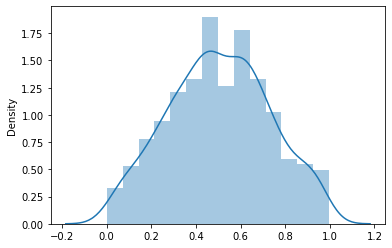

In [387]:
z = scatters['loc'][:,2].cpu().detach().numpy()
m = (z>0)*(z<1)
sns.distplot(z[m])
z.mean()

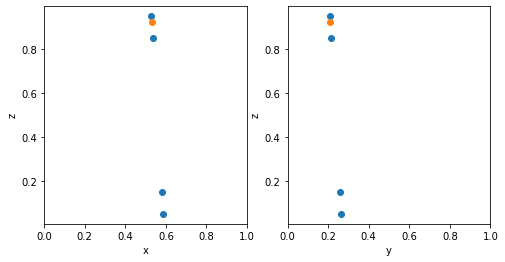

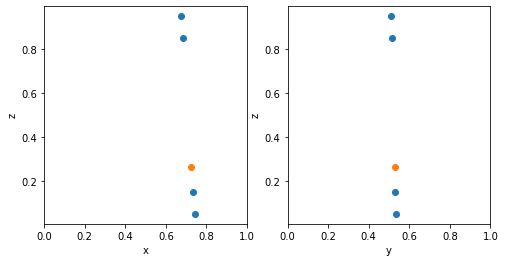

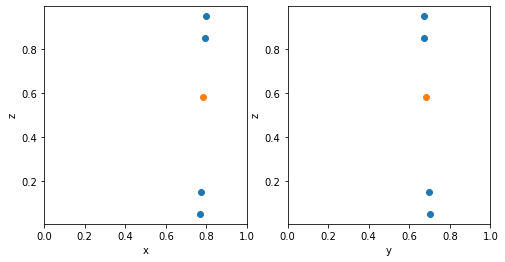

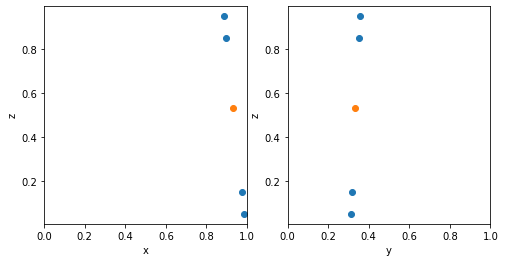

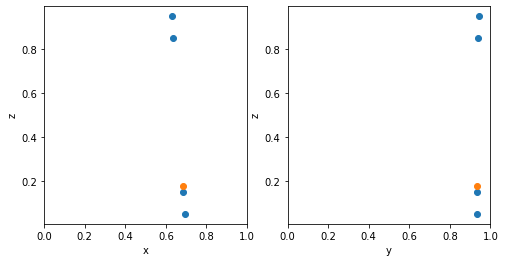

In [388]:
for i in range(5): plot_hits(i, hits, scatters['loc'])

## Infer rad length

### Preds per muon

In [389]:
mask = (scatters['loc'][:,2] >= 0.2)*(scatters['loc'][:,2] < 0.8)

In [390]:
a = 0.038
b = 0.0136
p = batch.p[batch.get_xy_mask(Tensor([1,1]))][mask]

In [408]:
# X0 from dtheta # Debias by considering each voxel on muon paths
size = 0.1  # extract this from volume
theta2 = scatters['dtheta'][mask].pow(2).sum(1)
theta2_unc = (2*scatters['dtheta'][mask]*scatters['dtheta_unc'][mask]).pow(2).sum(1).sqrt()
n_x0 = 0.5*theta2*((p/b)**2)
n_x0_unc = 0.5*theta2_unc*((p/b)**2)
theta_in2 = scatters['theta_in'][mask].pow(2).sum(1)
theta_in = theta_in2.sqrt()
theta_out = scatters['theta_out'][mask].pow(2).sum(1).sqrt()
theta_in2_unc = (2*scatters['theta_in'][mask]*scatters['theta_in_unc'][mask]).pow(2).sum(1).sqrt()
theta_in_unc = 0.5*theta_in2_unc/theta_in
theta_out2_unc = (2*scatters['theta_out'][mask]*scatters['theta_out_unc'][mask]).pow(2).sum(1).sqrt()
theta_out_unc = 0.5*theta_out2_unc/theta_out
cos_theta_in = torch.cos(theta_in)
cos_theta_in_unc = torch.sin(theta_in)*theta_in_unc
cos_theta_out = torch.cos(theta_out)
cos_theta_out_unc = torch.sin(theta_out)*theta_out_unc
cos_sum = cos_theta_in+cos_theta_out
cos_sum_unc = torch.sqrt(cos_theta_in_unc.pow(2)+cos_theta_out_unc.pow(2))
x0_pred_dtheta = n_x0*cos_sum/(0.5*size)
x0_pred_dtheta_unc = x0_pred_dtheta*torch.sqrt((n_x0_unc/n_x0).pow(2)+(cos_sum_unc/cos_sum).pow(2))

In [409]:
x0_pred_dtheta[:10], x0_pred_dtheta_unc[:10]

(tensor([0.7472, 1.8113, 1.2842, 0.0993, 2.2657, 0.1960, 0.2052, 0.3763, 1.0833,
         3.0748], grad_fn=<SliceBackward>),
 tensor([0.9081, 1.6415, 1.4332, 0.1968, 1.9373, 0.4043, 0.3658, 1.0240, 1.1831,
         4.3326], grad_fn=<SliceBackward>))

In [410]:
X0['aluminium'], X0['lead']

(8.897, 0.5612)

In [411]:
dets = volume.get_detectors()

In [412]:
#might be incorrect
size = 0.1
dxy = torch.sqrt(scatters['dxy'][mask].pow(2).sum(1))
dh = dxy/((math.sqrt(2)*torch.cos(scatters['theta_in'][mask].pow(2).sum(1)))+1e-17)
theta0 = torch.arcsin(dh/size)
x0_pred_dxy = (theta0*p/b)**2

In [413]:
x0_pred_dxy[:10]

tensor([4.6652e+02, 1.7599e+03, 1.1096e+01, 7.0883e+02, 1.2419e+03, 4.8052e+03,
        1.5425e+03, 1.1778e+04, 1.6275e+02, 9.0291e-01],
       grad_fn=<SliceBackward>)

### Efficiency

In [414]:
eff = None
for p,l,i in zip(('above','above','below','below'),dets,(0,1,0,1)):
    x = l.abs2idx(hits[p]['xy'][:,i][mask])
    e = l.efficiency[x[:,0],x[:,1]]
    if eff is None: eff = e
    else:           eff = eff*e

### Preds per voxel

In [415]:
loc, loc_unc, x0, x0_unc = scatters['loc'][mask], scatters['loc_unc'][mask], x0_pred_dtheta, x0_pred_dtheta_unc

In [416]:
loc, loc_unc

(tensor([[0.7265, 0.5289, 0.2631],
         [0.7854, 0.6815, 0.5842],
         [0.9329, 0.3345, 0.5326],
         ...,
         [0.9578, 0.7456, 0.3719],
         [0.3773, 0.7355, 0.7142],
         [0.3995, 0.3161, 0.6062]], grad_fn=<IndexBackward>),
 tensor([[0.0191, 0.0068, 0.2684],
         [0.0070, 0.0075, 0.2303],
         [0.0252, 0.0118, 0.2352],
         ...,
         [0.0360, 0.0409, 0.6368],
         [0.0472, 0.0983, 0.5188],
         [0.0126, 0.0410, 0.2174]], grad_fn=<IndexBackward>))

In [417]:
loc_idx = volume.lookup_coords(loc, passive_only=True); loc_idx

tensor([[7, 5, 0],
        [7, 6, 3],
        [9, 3, 3],
        ...,
        [9, 7, 1],
        [3, 7, 5],
        [3, 3, 4]])

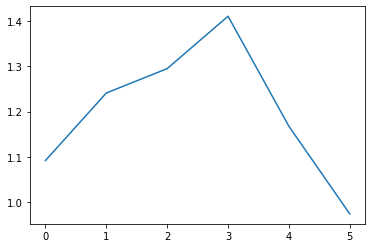

In [418]:
pred,z = [],range(6)
for i in z: pred.append(x0[loc_idx[:,2]==i].mean().detach().numpy())
plt.plot(z,pred)

In [419]:
#vectorise this
rad_pred = (nn.init.zeros_(volume.get_rad_cube()))
weights = rad_pred.clone()
for i in range(len(loc)):
    rad_pred[loc_idx[i,2],loc_idx[i,0],loc_idx[i,1]] = rad_pred[loc_idx[i,2],loc_idx[i,0],loc_idx[i,1]]+(eff[i]*x0[i]/(1e-17+x0_unc[i]**2))
    weights[loc_idx[i,2],loc_idx[i,0],loc_idx[i,1]] = weights[loc_idx[i,2],loc_idx[i,0],loc_idx[i,1]]+(eff[i]/(1e-17+x0_unc[i]**2))

In [420]:
rad_pred.shape

torch.Size([6, 10, 10])

In [421]:
len(loc)

545

In [422]:
rad_pred = rad_pred/weights

In [423]:
rad_pred

tensor([[[   nan,    nan,    nan,    nan,    nan,    nan, 1.0551,    nan,
          0.9998,    nan],
         [   nan, 3.1370,    nan, 1.0164, 0.7188, 0.0774,    nan,    nan,
             nan,    nan],
         [0.4547, 0.9768,    nan,    nan, 0.9801, 0.8497, 0.0415, 0.1089,
          0.1270,    nan],
         [   nan,    nan, 0.8622,    nan, 0.6397,    nan,    nan, 0.4911,
             nan,    nan],
         [   nan,    nan,    nan, 1.1855, 0.8166, 0.7714, 1.8948, 0.7322,
          0.2187, 1.2406],
         [   nan,    nan, 0.7500, 0.5181, 0.1872, 1.5042,    nan, 1.9541,
          1.1646,    nan],
         [   nan,    nan, 0.3875, 1.2878,    nan, 0.6842,    nan,    nan,
          1.2118,    nan],
         [   nan, 1.2476,    nan, 0.7072,    nan, 0.9140,    nan, 0.7412,
          0.2393,    nan],
         [   nan,    nan, 0.5782, 0.7638, 2.5307, 2.0990,    nan,    nan,
          1.4864,    nan],
         [   nan, 0.2030,    nan,    nan, 0.0645, 0.0869, 2.7741,    nan,
             nan,

In [424]:
rad_true = volume.get_rad_cube()

In [425]:
m = rad_pred == rad_pred
rad_pred[~m] = X0['beryllium']
weights[~m] = 1/(X0['beryllium']**2)
mfse = ((rad_pred-rad_true).pow(2)*weights).mean()  # weights is inverse variance
mfse

tensor(162.0955, grad_fn=<MeanBackward0>)

In [425]:
m = rad_pred == rad_pred
rad_pred[~m] = X0['beryllium']
mfse = (rad_pred-rad_true).pow(2).mean()  # weights is inverse variance
mfse

tensor(162.0955, grad_fn=<MeanBackward0>)

# Loss

preselect voxels with sufficient illumination

In [ ]:
class DetectorLoss(nn.Module):
    def __init__(self, cost_coef:float):
        super().__init__()
        self.cost_coef = cost_coef
        
    def get_hit_loss(self, mu:MuonBatch) -> Tensor:
        
        
    def forward(self, mu:MuonBatch, cost:Tensor) -> Tensor:
        loss = self.get_hit_loss(mu)
        loss = loss+(self.cost_coef*cost)
        return loss